# Qisit ML - Supervised clustering

Authors: Tomasz Stopa, Gregoire Cattan

### Setup

In [1]:
!pip install pyRiemann-qiskit
!pip install covmatest
!pip install pylatexenc

DEPRECATION: qiskit-nature 0.5.0 has a non-standard dependency specifier qiskit-terra>=0.22.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of qiskit-nature or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\alaga\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


DEPRECATION: qiskit-nature 0.5.0 has a non-standard dependency specifier qiskit-terra>=0.22.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of qiskit-nature or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\alaga\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


DEPRECATION: qiskit-nature 0.5.0 has a non-standard dependency specifier qiskit-terra>=0.22.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of qiskit-nature or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\alaga\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from pyriemann_qiskit.classification import (
    QuanticMDM,
)
from pyriemann.tangentspace import TangentSpace
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZFeatureMap
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.kernels.quantum_kernel import QuantumKernel
from qiskit_aer import AerSimulator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from covmatest import get_covmat
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

C:\Users\alaga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


### Prepare data

In [3]:
n_matrices = 100
n_channels = 2
A = get_covmat(n_matrices, n_channels)
B = get_covmat(n_matrices, n_channels) * 2
X = np.concatenate((A, B))
y = np.array([0] * n_matrices + [1] * n_matrices)

SHA256 hash of downloaded file: 9db2e0f7ff016c8ab0fe5a151f085ddb14a20d3fcd91ee0f9c67f736008d925c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [4]:
# Let's keep it simple without cross-validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)

### Classification

In [5]:
# Instantiate our pipeline (inherits from sklearn mixins)
clf = QuanticMDM(
    metric={"mean": "logeuclid", "distance": "convex"},
    quantum=True,
    verbose=True,
    shots=100,
)
display(clf)

[QClass]  Initializing Quantum Classifier


QuanticMDM(shots=100)

In [6]:
# TODO: Fit transformer
clf.fit(X_train, y_train)

[QClass]  seed =  964740
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (160, 2, 2)
[QClass]  Feature dimension =  2
[QClass]  Convex MDM initiating algorithm
[QClass]  Using NaiveQAOAOptimizer
[QClass]  Training...


QuanticMDM(shots=100)

In [7]:
# TODO: get prediction
X_pred = clf.predict(X_test)
score = accuracy_score(y_test, X_pred)

[QClass]  Prediction:  (40, 2, 2)
[QClass]  Prediction finished.


### Results

In [8]:
# Note: use only with balanced data!
score = accuracy_score(y_test, X_pred)

# Do not pay to much attention to the score.
# There is no cross-validation here.
# It likely just depends on the random_state.
print(f"score = {score}")

score = 0.8


### References

Github Repo: https://github.com/pyRiemann/pyRiemann-qiskit

API Documentation & Examples: https://pyriemann-qiskit.readthedocs.io

Paper: [pyRiemann-qiskit: A Sandbox for Quantum Classification Experiments with Riemannian Geometry](https://hal.science/hal-04040814/document)


# Qiskit ML - VQC

In [9]:
# We will add a callback function called callback_graph.
# This will be called for each iteration of the optimizer and will be passed
# two parameters: the current weights and the value of the objective function at those weights.
# For our function, we append the value of the objective function to an array so we can plot iteration
# versus objective function value and update the graph with each iteration.
# However, you can do whatever you want with a callback function as long as it gets the two
# parameters mentioned passed.

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [10]:
# TODO: Transform matrices to vectors
# ts = X_test.flatten()
# ts = []
# for el in X_test:
#     ts.append(el[0][0])
# ts = np.array(ts)
# # TODO: get vector dimension
ts = TangentSpace(metric="riemann")
tsx = ts.fit_transform(X_train)
feature_dim = tsx.shape[1]

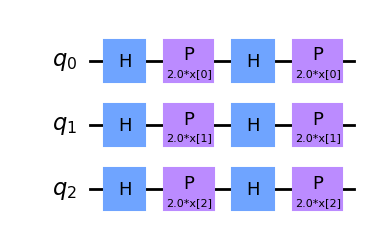

In [11]:
# instanciate FeatureMap
feature_map = ZFeatureMap(feature_dim, reps=2)
feature_map.decompose().draw(output="mpl")

In [12]:
# instanciate ansatz
ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
ansatz.decompose().draw()

┌──────────┐┌──────────┐      ┌──────────┐┌──────────┐                   »
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├─■──■─┤ Ry(θ[6]) ├┤ Rz(θ[9]) ├──────────────■──■─»
     ├──────────┤├──────────┤ │  │ └──────────┘├──────────┤┌───────────┐ │  │ »
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├─■──┼──────■──────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├─■──┼─»
     ├──────────┤├──────────┤    │      │      ├──────────┤├───────────┤    │ »
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├────■──────■──────┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├────■─»
     └──────────┘└──────────┘                  └──────────┘└───────────┘      »
«     ┌───────────┐┌───────────┐                   ┌───────────┐┌───────────┐»
«q_0: ┤ Ry(θ[12]) ├┤ Rz(θ[15]) ├──────────────■──■─┤ Ry(θ[18]) ├┤ Rz(θ[21]) ├»
«     └───────────┘├───────────┤┌───────────┐ │  │ └───────────┘├───────────┤»
«q_1: ──────■──────┤ Ry(θ[13]) ├┤ Rz(θ[16]) ├─■──┼───────■──────┤ Ry(θ[19]) ├»
«           │      ├───────────┤├───────────┤    │       │      ├───────────┤»
«q_2: ──────■──────┤ Ry(θ[14]) ├┤ Rz(θ[17]) ├────■───────■──────┤ Ry(θ[20]) ├»
«                  └───────────┘└───────────┘                   └───────────┘»
«                  
«q_0: ─────────────
«     ┌───────────┐
«q_1: ┤ Rz(θ[22]) ├
«     ├───────────┤
«q_2: ┤ Rz(θ[23]) ├
«     └───────────┘

In [13]:
quantum_instance = QuantumInstance(AerSimulator(method="statevector"), shots=1024)

In [15]:
# TODO: instanciate VQC and fit the estimator
from qiskit.primitives import Sampler

vqc = VQC(
    num_qubits=feature_dim,
    ansatz=ansatz,
    sampler=Sampler(),
    quantum_instance=quantum_instance,
    feature_map=feature_map,
)
vqc.fit(tsx, y_train)

In [ ]:
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Score: {score:0.2f}")

# Qiskit ML - SVM

In [ ]:
quantum_kernel = QuantumKernel(quantum_instance)
svc = QSVC(
    quantum_kernel=quantum_kernel,
    # gamma=self.gamma,
    # C=self.C,
    # max_iter=70,
)
clf = make_pipeline(ts, svc)

clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Score: {score:0.2f}")

# TODO: Retry with different value of gamma and C
#       Use a grid searchCV